# Get Immutable Reference Benchmarks

In [1]:
# select measurement file
files = [
    "../output/2024-12-07 15-42-29.json",
    "../output/2024-12-01 20-13-22 storage.json"
]

# plot settings
show_error_bar = False
unit = "ms"

In [2]:
# parse data
import json

raw_data = []
for file_name in files:
    with open(file_name) as file:
        raw_data.extend(json.load(file))

In [3]:
from util.convert import convert_datasets
import pandas as pd

ovpm = convert_datasets(
    raw_data,
    "Storage",
    [("persistent_storage_write", "Storage Write")],
    ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

baseline = convert_datasets(
    raw_data,
    "Persist",
    [("worst_case_persist_latency_dirty_size", "Worst Case"), ("max_dirty_persist_latency_dirty_size", "Max Dirty"), ("worst_case_persist_latency_buffer_size", "Worst Case Buffer"), ("max_dirty_persist_latency_buffer_size", "Max Dirty Buffer")],
    ["mean", "min", "max", "options.dirty_size", "options.buffer_size", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

dataset = pd.concat([ovpm, baseline])
dataset.head()

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms,dataset_type,benchmark_title,benchmark_id,options.dirty_size,options.buffer_size
0,5754.5,5214,10619,0.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN
1,6007.7,5473,10815,16.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN
2,6133.4,5599,10941,32.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN
3,6261.4,5727,11069,48.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN
4,6387.3,5853,11195,64.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN


In [4]:
from util.convert import display_dataset_infos

display_dataset_infos(dataset)

min     359.65625
max    5466.51250
Name: mean, dtype: float64

min     453.36250
max    2774.45625
Name: mean, dtype: float64

min     453.3625
max    3211.4375
Name: mean, dtype: float64

min     572.3000
max    1768.9625
Name: mean, dtype: float64

min     599.88750
max    1818.59375
Name: mean, dtype: float64

# Final Plot

<Axes: xlabel='Max Dirty Size', ylabel='Latency in ms'>

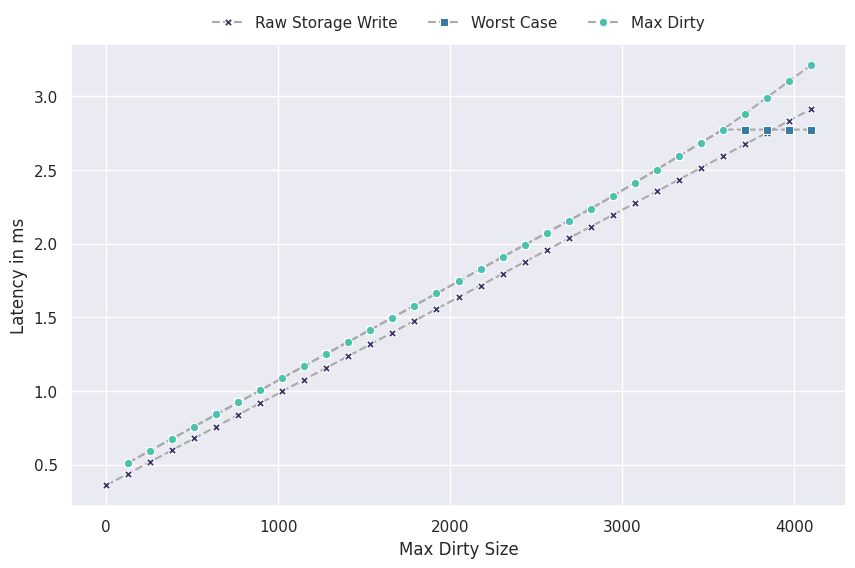

In [5]:
from typing import NamedTuple
from util import convert
from util.plot import plot_lines, PlotLinesOptions, LinePlotEntry

scale = 128

plot_data = [{
    "name": "Raw Storage Write",
    "x": "options.object_size",
    "y": "mean",
    "marker": "X",
    "data": dataset[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] <= 4 * 1024) & (dataset["options.object_size"] % scale == 0)],
},{
    "name": "Worst Case",
    "x": "options.dirty_size",
    "y": "mean",
    "marker": "s",
    "data": dataset[(dataset["benchmark_id"] == "worst_case_persist_latency_dirty_size") & (dataset["options.dirty_size"] % scale == 0)],
},{
    "name": "Max Dirty",
    "x": "options.dirty_size",
    "y": "mean",
    "marker": "o",
    "data": dataset[(dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size") & (dataset["options.dirty_size"] % scale == 0)],
}]

options = {
    "data": plot_data,
    "scale": unit,
    "x_label": "Max Dirty Size",
    "y_label": f"Latency in {unit}",
}

plot_lines(options)

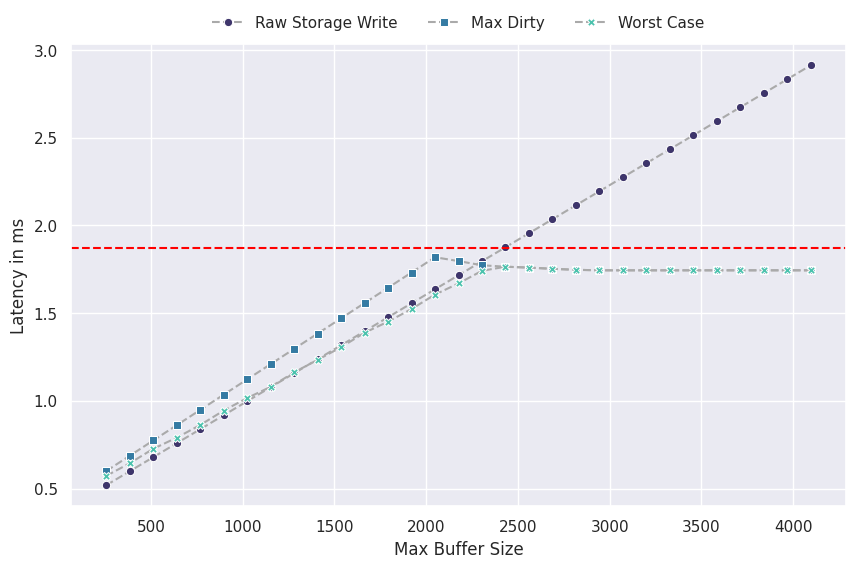

In [33]:
from typing import NamedTuple
from util import convert
from util.plot import plot_lines, PlotLinesOptions, LinePlotEntry
import seaborn as sbn

scale = 128

plot_data = [{
    "name": "Raw Storage Write",
    "x": "options.object_size",
    "y": "mean",
    "marker": "o",
    "data": dataset[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] <= 4 * 1024) & (dataset["options.object_size"] >= 256) & (dataset["options.object_size"] % scale == 0)],
},{
    "name": "Max Dirty",
    "x": "options.buffer_size",
    "y": "mean",
    "marker": "s",
    "data": dataset[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (dataset["options.buffer_size"] % scale == 0)],
},{
    "name": "Worst Case",
    "x": "options.buffer_size",
    "y": "mean",
    "marker": "X",
    "data": dataset[(dataset["benchmark_id"] == "worst_case_persist_latency_buffer_size") & (dataset["options.buffer_size"] % scale == 0)],
}]

options = {
    "data": plot_data,
    "scale": unit,
    "x_label": "Max Buffer Size",
    "y_label": f"Latency in {unit}",
}

ax = plot_lines(options)

offset_multiplier = 0.03
scaled = convert.scale_data(dataset[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (dataset["options.buffer_size"] % scale == 0)], unit)
line = scaled["mean"].max() + scaled["mean"].max() * offset_multiplier
ax.axhline(line, ls='--', color="red")